In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import linregress
import ast


In [31]:
#eventid2name.csv
#events_England.csv
#matches_England.csv 
#tags2name.csv

In [32]:
events = pd.read_csv('data/events_England.csv')

## About this file

This dataset describes all the events that occur during each match. Each event refers to a ball touch and contains the following information:

- **eventId**: the identifier of the event's type. Each eventId is associated with an event name.
- **eventName**: the name of the event's type (pass, foul, shot, duel, free kick, offside, or touch).
- **subEventId**: the identifier of the subevent's type.
- **subEventName**: the name of the subevent's type, associated with different event types.
- **tags**: a list of event tags providing additional information about the event (e.g., accurate).
- **eventSec**: the time the event occurs (in seconds since the beginning of the current half).
- **id**: a unique identifier of the event.
- **matchId**: the identifier of the match, linked to "wyId" in the match dataset.
- **matchPeriod**: the period of the match ("1H", "2H", "E1", "E2", or "P").
- **playerId**: the identifier of the player who generated the event, linked to "wyId" in a player dataset.
- **positions**: the origin and destination positions associated with the event as (x, y) coordinates.
- **teamId**: the identifier of the player's team, linked to "wyId" in the team dataset.
- **tagsList**: same information as the tags column, except in list format.
- **pos_orig_x**: from the positions column, origin in x-axis.
- **pos_orig_y**: from the positions column, origin in y-axis.
- **pos_dest_x**: from the positions column, destination in x-axis.
- **pos_dest_y**: from the positions column, destination in y-axis.


In [33]:
len(events)

643090

In [34]:
events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85.0,177959171,[1801],49,49,78,31
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83.0,177959172,[1801],78,31,75,51
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82.0,177959173,[1801],75,51,71,35
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82.0,177959174,[1801],71,35,95,41
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85.0,177959175,[1801],95,41,88,72


I am going to drop the positions and tags columns because that information is already parsed out in the table in other columns

In [35]:
events.drop(['tags'], axis=1, inplace=True)

### eventName

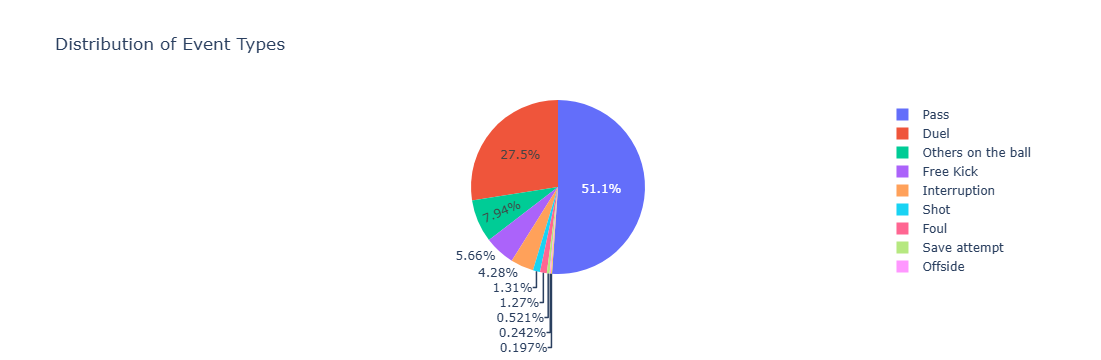

In [36]:
# Count occurrences of each event name
event_counts = events['eventName'].value_counts().reset_index()
event_counts.columns = ['eventName', 'count']

# Plot the pie chart
fig = px.pie(event_counts, names='eventName', values='count', title='Distribution of Event Types')
fig.show()

Interestingly, the vast majority of events are passes or duels. Shots and fouls make up a tiny portion. I am not sure why there are so many more free kicks than there are fouls and offsides though. I will investigate.

In [37]:
events[events['eventName']=='Free Kick']['subEventName'].value_counts()

subEventName
Throw in           17050
Free Kick           7277
Goal kick           6061
Corner              3909
Free kick cross     1693
Free kick shot       350
Penalty               80
Name: count, dtype: int64

Oh, makes sense. Most of them are throw Ins. and the sub-event "Free Kick" within the Free Kick's events matches up much closer with foul count.

So the sub-events in this field are not exactly what I would expect. I will check all the event's sub-events. 

but, I will need to map in the tags2name.csv data. 

In [38]:
#this looks as expected
events[events['eventName']=='Pass']['subEventName'].value_counts()

subEventName
Simple pass    251377
High pass       25064
Head pass       21332
Cross           12249
Launch          10247
Smart pass       5881
Hand pass        2474
Name: count, dtype: int64

In [39]:
events[events['eventName']=='Duel']['subEventName'].value_counts()

subEventName
Ground attacking duel     53854
Ground defending duel     53732
Air duel                  37758
Ground loose ball duel    31330
Name: count, dtype: int64

In [40]:
events[events['eventName']=='Others on the ball']['subEventName'].value_counts()

subEventName
Touch           34405
Clearance       11784
Acceleration     4890
Name: count, dtype: int64

In [41]:
events[events['eventName']=='Interruption']['subEventName'].value_counts()

subEventName
Ball out of the field    27330
Whistle                    204
Name: count, dtype: int64

In [42]:
events[events['eventName']=='Shot']['subEventName'].value_counts()

subEventName
Shot    8450
Name: count, dtype: int64

In [43]:
events[events['eventName']=='Foul']['subEventName'].value_counts()

subEventName
Foul                7520
Hand foul            275
Out of game foul      97
Protest               84
Late card foul        70
Time lost foul        48
Simulation            28
Violent Foul          14
Name: count, dtype: int64

In [44]:
events[events['eventName']=='Save attempt']['subEventName'].value_counts()

subEventName
Reflexes        2124
Save attempt    1225
Name: count, dtype: int64

In [45]:
#subEventName doesnt exist for Offside. So maybe i should just populate this with offside.
events[events['eventName']=='Offside']

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
267,6,NaN,3319,"[{'y': 34, 'x': 87}, {'y': 0, 'x': 0}]",2499719,Offside,1609,1H,851.290742,NaN,177959447,NaN,34,87,0,0
303,6,NaN,12829,"[{'y': 15, 'x': 81}, {'y': 100, 'x': 100}]",2499719,Offside,1631,1H,996.305819,NaN,177959514,NaN,15,81,100,100
431,6,NaN,25413,"[{'y': 43, 'x': 75}, {'y': 0, 'x': 0}]",2499719,Offside,1609,1H,1358.933267,NaN,177959644,NaN,43,75,0,0
660,6,NaN,7945,"[{'y': 15, 'x': 89}, {'y': 0, 'x': 0}]",2499719,Offside,1609,1H,2023.671828,NaN,177959883,NaN,15,89,0,0
870,6,NaN,26150,"[{'y': 94, 'x': 56}, {'y': 100, 'x': 100}]",2499719,Offside,1631,1H,2752.836986,NaN,177960104,NaN,94,56,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641960,6,NaN,14703,"[{'y': 34, 'x': 76}, {'y': 0, 'x': 0}]",2500098,Offside,1633,1H,853.798965,NaN,251595083,NaN,15,85,13,55
642090,6,NaN,14703,"[{'y': 27, 'x': 61}, {'y': 0, 'x': 0}]",2500098,Offside,1633,1H,1577.553216,NaN,251595216,NaN,81,57,84,41
642768,6,NaN,14703,"[{'y': 31, 'x': 94}, {'y': 0, 'x': 0}]",2500098,Offside,1633,2H,1198.739889,NaN,251595871,NaN,65,72,27,71
642814,6,NaN,14703,"[{'y': 48, 'x': 92}, {'y': 0, 'x': 0}]",2500098,Offside,1633,2H,1430.887828,NaN,251595929,NaN,68,97,100,100


In [46]:
#Amazing, the nulls in subEventName are all simple offsides. I will fill those nulls in with that value.
events[events['eventName']=='Offside'].equals(events[events['subEventName'].isna()])

True

### Investigating the tagList field

In [47]:
events['tagsList'].value_counts()

tagsList
[1801]                          278015
[1802]                           47568
[701, 1802]                      44964
[703, 1801]                      44575
[702, 1801]                      32342
                                 ...  
[301, 401, 1210, 1802]               1
[402, 1401, 201, 1204, 1801]         1
[201, 1301]                          1
[1901, 504, 602, 701, 1802]          1
[402, 1206, 1802]                    1
Name: count, Length: 713, dtype: int64

I am going to need to replace these with the label information in the tags2Name table

I will need to explode the taglist field, then do the join, and then regroup by index

### tags2name

In [48]:
tags2name = pd.read_csv('data/tags2name.csv')

In [49]:
tags2name.head()

,Tag,Label,Description
0,101,Goal,Goal
1,102,own_goal,Own goal
2,301,assist,Assist
3,302,keyPass,Key pass
4,1901,counter_attack,Counter attack


In [50]:
%%time
##takes about 42 seconds to run

#getting the list values out of the string values in the tagList column
events['tagsList'] = events['tagsList'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#explode the tagsList column because we will get the labels
exploded_events = events.explode('tagsList')

#cast to int because the column in the tags table is int
exploded_events['tagsList']=exploded_events['tagsList'].astype('Int64')

#keep the original index because I was losing this information in the merge 
exploded_events['origIndex']=exploded_events.index

#get the tag labels
exploded_merged_events=exploded_events.merge(tags2name[['Tag','Label']], left_on='tagsList', right_on='Tag', how='left')

#grouping by original index to prepare for the join back to events table
exploded_merged_events=exploded_merged_events.groupby('origIndex').agg({
   # 'tagsList': list, 
   # 'Tag': list,
    'Label': list
}).reset_index()

#joining back onto original events table
events=pd.concat([events, exploded_merged_events['Label']], axis=1)

CPU times: user 24.3 s, sys: 6.31 s, total: 30.6 s
Wall time: 44.2 s


In [51]:
tags2name

,Tag,Label,Description
0,101,Goal,Goal
1,102,own_goal,Own goal
2,301,assist,Assist
3,302,keyPass,Key pass
4,1901,counter_attack,Counter attack
5,401,Left,Left foot
6,402,Right,Right foot
7,403,head/body,Head/body
8,1101,direct,Direct
9,1102,indirect,Indirect


#### counting tags by event type where event type is pass

In [52]:
events['Label']

0         [accurate]
1         [accurate]
2         [accurate]
3         [accurate]
4         [accurate]
             ...    
643085    [accurate]
643086    [accurate]
643087    [accurate]
643088    [accurate]
643089    [accurate]
Name: Label, Length: 643090, dtype: object

In [53]:
#events['tagLabels_str'] = events['tagLabels'].astype(str)

# Filter for 'Pass' events and group by the modified 'tagLabels' column
events[events['eventName'] == 'Pass'].groupby( events['Label'].astype(str)).size().reset_index().sort_values(by=0, ascending=False).head()

,Label,0
18,['accurate'],251683
105,['not accurate'],39560
73,"['interception', 'accurate']",9629
109,"['through', 'not accurate']",3959
74,"['interception', 'not accurate']",3932


In [54]:
#events['tagLabels_str'] = events['tagLabels'].astype(str)

# Filter for 'Pass' events and group by the modified 'tagLabels' column
events[events['eventName'] == 'Others on the ball'].groupby(events['Label'].astype(str)).size().reset_index().sort_values(by=0, ascending=False).head()

,Label,0
38,[nan],18244
26,['interception'],12960
25,"['interception', 'not accurate']",4808
30,['not accurate'],4724
1,['accurate'],4215


#### Rows that contain counter_attack in the tagLabels column

In [55]:
temp=events[events['Label'].apply(lambda x: 'counter_attack' in x)]
temp

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label
72,8,Simple pass,8013,"[{'y': 14, 'x': 53}, {'y': 7, 'x': 85}]",2499719,Pass,1631,1H,220.782446,85.0,177959254,"[1901, 1401, 1801]",14,53,7,85,"[counter_attack, interception, accurate]"
74,1,Ground attacking duel,12829,"[{'y': 7, 'x': 85}, {'y': 10, 'x': 96}]",2499719,Duel,1631,1H,227.006908,11.0,177959257,"[1901, 502, 703, 1801]",7,85,10,96,"[counter_attack, free_space_l, won, accurate]"
75,8,Cross,12829,"[{'y': 10, 'x': 96}, {'y': 100, 'x': 100}]",2499719,Pass,1631,1H,228.764258,80.0,177959258,"[1901, 401, 2101, 1802]",10,96,100,100,"[counter_attack, Left, blocked, not accurate]"
338,1,Ground attacking duel,25413,"[{'y': 30, 'x': 62}, {'y': 28, 'x': 62}]",2499719,Duel,1609,1H,1118.937573,11.0,177959537,"[1901, 503, 703, 1801]",30,62,28,62,"[counter_attack, take_on_l, won, accurate]"
585,1,Ground defending duel,8653,"[{'y': 46, 'x': 22}, {'y': 37, 'x': 23}]",2499719,Duel,1631,1H,1839.697675,12.0,177959776,"[1901, 703, 1801]",46,22,37,23,"[counter_attack, won, accurate]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642926,8,Simple pass,41174,"[{'y': 33, 'x': 62}, {'y': 27, 'x': 73}]",2500098,Pass,1633,2H,1886.598773,85.0,251596034,"[1901, 1801]",44,19,43,20,"[counter_attack, accurate]"
642927,7,Acceleration,14703,"[{'y': 27, 'x': 73}, {'y': 39, 'x': 91}]",2500098,Others on the ball,1633,2H,1888.150308,70.0,251596037,"[1901, 1801]",43,20,43,24,"[counter_attack, accurate]"
642928,1,Ground attacking duel,14703,"[{'y': 39, 'x': 91}, {'y': 34, 'x': 88}]",2500098,Duel,1633,2H,1891.236739,11.0,251596040,"[1901, 502, 602, 703, 1801]",57,80,57,76,"[counter_attack, free_space_l, anticipation, w..."
642929,8,Simple pass,14703,"[{'y': 34, 'x': 88}, {'y': 57, 'x': 91}]",2500098,Pass,1633,2H,1893.514543,85.0,251596038,"[1901, 1801]",57,76,75,90,"[counter_attack, accurate]"


In [56]:
temp[['eventName','subEventName']].value_counts()

eventName                subEventName           
Pass                     Simple pass                3447
Duel                     Ground attacking duel      1241
Others on the ball       Acceleration                915
Duel                     Ground defending duel       541
Others on the ball       Touch                       530
Shot                     Shot                        425
Pass                     High pass                   407
                         Smart pass                  397
                         Cross                       366
Duel                     Ground loose ball duel      280
                         Air duel                    234
Pass                     Head pass                   208
Others on the ball       Clearance                   139
Pass                     Hand pass                    86
Goalkeeper leaving line  Goalkeeper leaving line      66
Pass                     Launch                       57
Save attempt             Save attempt  

### positional data looks very weird

the pos_orig_y	pos_orig_x	pos_dest_y	pos_dest_x	data seems junk to me. Because i researched some actual goals from some of the matches and they dont match up the pos columns at all.

But the first X value in the positions column seems to actually have some correct data.

I filtered for all goals where x<70 and indeed they equate to long shot goals. Noteably Wayne Rooney's goal from his own half is also there.

I think I will just use this one positional coordinate for now.

I actually since found this project:
https://www.kaggle.com/code/mikolajhojda/what-is-expected-goals-xg

It looks like the author also used the first X value to judge distance. 

In [57]:
events['positions'] = events['positions'].apply(ast.literal_eval)

events[(events['eventName']=='Shot') &
        (events['Label'].apply(lambda x: 'Goal' in x)) &
        (events['positions'].apply(lambda x: x[0]['x'] < 70))
]


,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label
51952,10,Shot,9206,"[{'y': 67, 'x': 67}, {'y': 0, 'x': 0}]",2499751,Shot,1646,1H,170.935625,100.0,186144087,"[101, 402, 201, 1201, 1801]",72,28,64,34,"[Goal, Right, opportunity, gb, accurate]"
230690,10,Shot,7944,"[{'y': 40, 'x': 44}, {'y': 0, 'x': 0}]",2499856,Shot,1623,2H,1254.782389,100.0,210484394,"[101, 402, 201, 1203, 1801]",46,22,51,31,"[Goal, Right, opportunity, gc, accurate]"
351100,10,Shot,14911,"[{'y': 50, 'x': 69}, {'y': 0, 'x': 0}]",2499926,Shot,1624,2H,2292.068408,100.0,218870556,"[101, 402, 201, 1209, 1801]",64,3,58,100,"[Goal, Right, opportunity, gtr, accurate]"
380034,10,Shot,120353,"[{'y': 34, 'x': 67}, {'y': 0, 'x': 0}]",2499943,Shot,1612,2H,1323.837327,100.0,220934410,"[101, 401, 1401, 201, 1201, 1801]",30,30,30,30,"[Goal, Left, interception, opportunity, gb, ac..."
479006,10,Shot,70122,"[{'y': 67, 'x': 67}, {'y': 100, 'x': 100}]",2500001,Shot,1611,2H,2748.607624,100.0,232587707,"[101, 401, 201, 1204, 1801]",4,81,4,81,"[Goal, Left, opportunity, gl, accurate]"
528901,10,Shot,54,"[{'y': 38, 'x': 69}, {'y': 100, 'x': 100}]",2500031,Shot,1624,1H,2714.685061,100.0,239137327,"[101, 402, 201, 1207, 1801]",77,69,21,32,"[Goal, Right, opportunity, gt, accurate]"


The positional data for goal kicks make no sense. I dont think the positonal data is that reliable.

In [108]:
events[events['subEventName']=='Goal kick'].head()

,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,id,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label,eventMinutes
64,Goal kick,7882,"[{'y': 0, 'x': 0}, {'y': 44, 'x': 28}]",2499719,Free Kick,1609,1H,196.066859,177959227,0,0,44,28,[nan],3.267781
130,Goal kick,8480,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 65}]",2499719,Free Kick,1631,1H,458.974297,177959339,100,100,47,65,[nan],7.649572
145,Goal kick,7882,"[{'y': 0, 'x': 0}, {'y': 47, 'x': 24}]",2499719,Free Kick,1609,1H,517.797223,177959306,0,0,47,24,[nan],8.629954
191,Goal kick,8480,"[{'y': 100, 'x': 100}, {'y': 28, 'x': 67}]",2499719,Free Kick,1631,1H,683.236107,177959384,100,100,28,67,[nan],11.387268
298,Goal kick,8480,"[{'y': 100, 'x': 100}, {'y': 21, 'x': 58}]",2499719,Free Kick,1631,1H,984.274294,177959505,100,100,21,58,[nan],16.404572


### eventid2name

In [58]:
#eventId refers to the eventName
events[['eventId','eventName']].value_counts()

eventId  eventName              
8        Pass                       328624
1        Duel                       176674
7        Others on the ball          51079
3        Free Kick                   36420
5        Interruption                27534
10       Shot                         8450
2        Foul                         8136
9        Save attempt                 3349
6        Offside                      1558
4        Goalkeeper leaving line      1266
Name: count, dtype: int64

The eventid2name is not needed as all that information is already in the event table

In [59]:

eventid2name = pd.read_csv('data/eventid2name.csv')

In [60]:
eventid2name.head()

,event,subevent,event_label,subevent_label
0,1,10,Duel,Air duel
1,1,11,Duel,Ground attacking duel
2,1,12,Duel,Ground defending duel
3,1,13,Duel,Ground loose ball duel
4,2,20,Foul,Foul


In [61]:
events.head()

,eventId,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tagsList,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label
0,8,Simple pass,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85.0,177959171,[1801],49,49,78,31,[accurate]
1,8,High pass,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83.0,177959172,[1801],78,31,75,51,[accurate]
2,8,Head pass,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82.0,177959173,[1801],75,51,71,35,[accurate]
3,8,Head pass,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82.0,177959174,[1801],71,35,95,41,[accurate]
4,8,Simple pass,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85.0,177959175,[1801],95,41,88,72,[accurate]


I got all the information from the tags2name table and the eventid2name tables. So I dont need the keys for those joins anymore. I will remove them now

In [62]:
events.drop(['eventId','subEventId','tagsList'], axis=1, inplace=True)

In [63]:
events.head()

,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,id,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label
0,Simple pass,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,177959171,49,49,78,31,[accurate]
1,High pass,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,177959172,78,31,75,51,[accurate]
2,Head pass,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,177959173,75,51,71,35,[accurate]
3,Head pass,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,177959174,71,35,95,41,[accurate]
4,Simple pass,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,177959175,95,41,88,72,[accurate]


I still have playerId, matchId and teamId so i will be using that for joins later. And I will trust these ids more than the ids from the teams data set because that is outdated (or the opposite...indated/futuredated)

before i continue with more joins, let me just investigate the events table itself and make sure things look as expected (I already looked at the event and subevent columns)

### matchPeriod

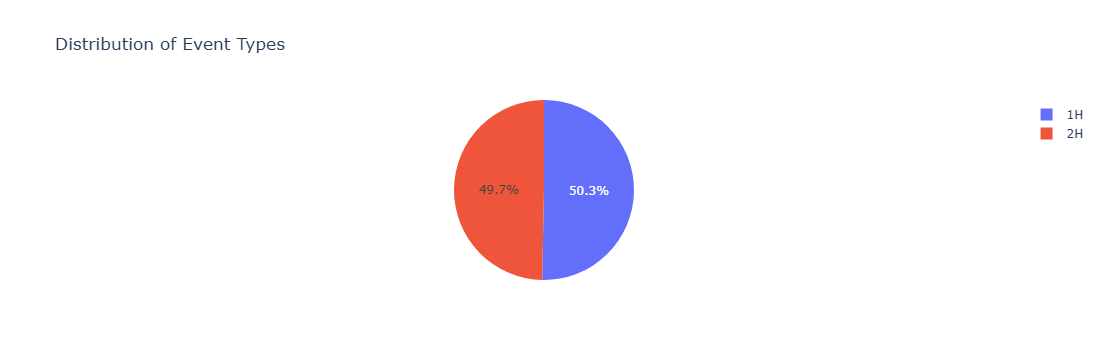

In [64]:
matchPeriod_counts=events['matchPeriod'].value_counts().reset_index()
# Plot the pie chart
fig = px.pie(matchPeriod_counts, names='matchPeriod', values='count', title='Distribution of Event Types')
fig.show()

fractionally more events happen in the first half of games.

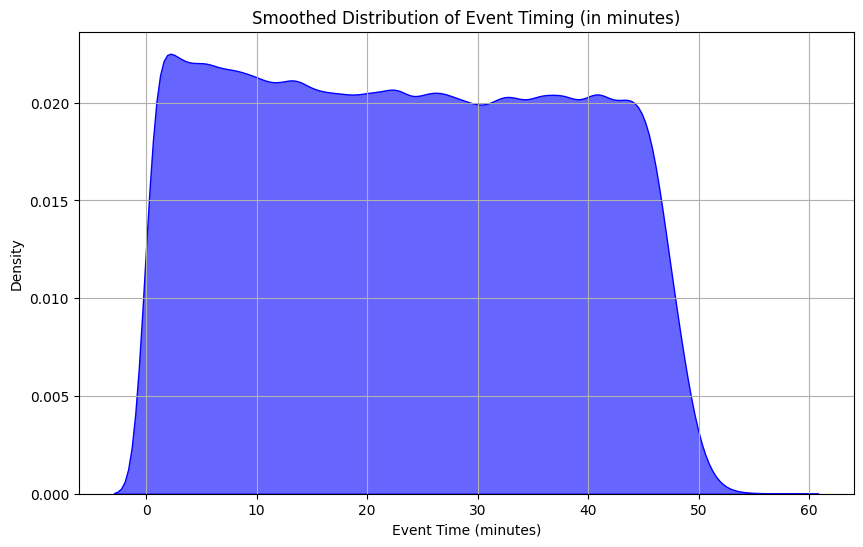

In [65]:
# Convert eventSec to minutes
events['eventMinutes'] = events['eventSec'] / 60

# Plotting the smoothed distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(events['eventMinutes'], fill=True, color='blue', alpha=0.6)
plt.title('Smoothed Distribution of Event Timing (in minutes)')
plt.xlabel('Event Time (minutes)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

This was unexpected. How is a 90 minute game all happening between 0 and 55 minutes? Good thing I converted the seconds to minutes or else I might not have caught this so early. I decided to dig into it and filter by first half events only. Then it became apparent that the time count restarts in the 2nd half. 



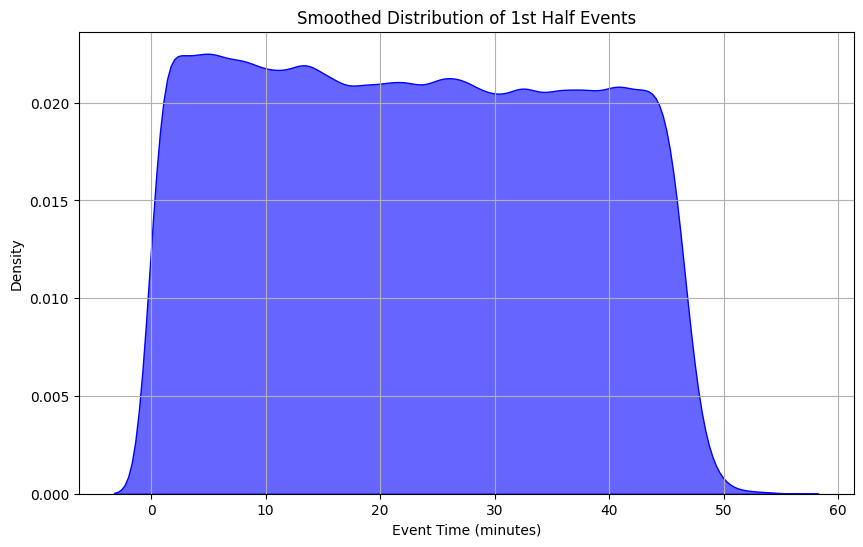

In [66]:

# Plotting the smoothed distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(events[events['matchPeriod']=='1H']['eventMinutes'], fill=True, color='blue', alpha=0.6)
plt.title('Smoothed Distribution of 1st Half Events')
plt.xlabel('Event Time (minutes)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

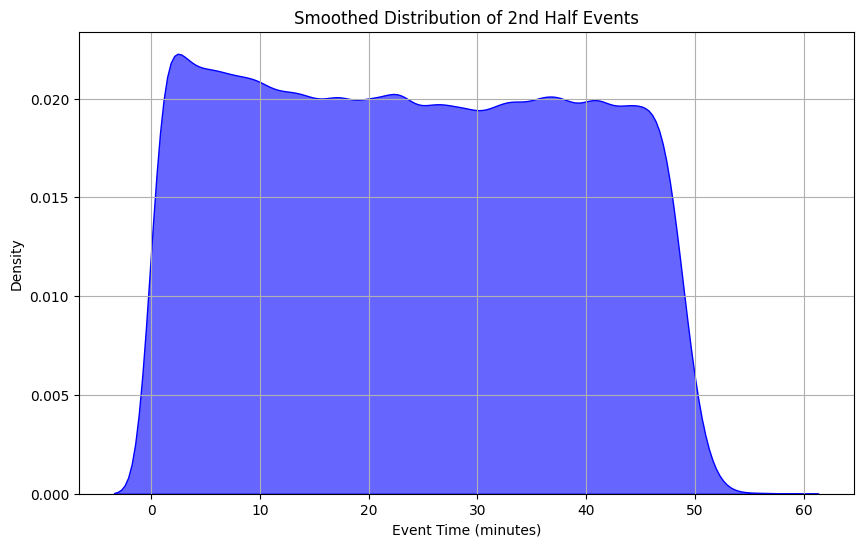

In [67]:


# Plotting the smoothed distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(events[events['matchPeriod']=='2H']['eventMinutes'], fill=True, color='blue', alpha=0.6)
plt.title('Smoothed Distribution of 2nd Half Events')
plt.xlabel('Event Time (minutes)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

I can see a bigger tail in the 2nd half density plot. This makes sense as there usually is more injury time added on in the 2nd half of games.

I need to consider how to deal with this time column.
- Should I just leave it as it is? 
- Should I add 45 minutes to all the 2nd half values?
- Should I add up each game's individual halves separately? Because the first half could end on something like 47 minutes, and this would be indistinguishable from the 2nd half's 2nd minute if i just did a simple add.

I will consider this later, but for now I dont see the need to change anything.

### Positional Data

I have since decided this is pretty much garbage

In [68]:
events[['pos_orig_y','pos_orig_x','pos_dest_y','pos_dest_x']]

,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
0,49,49,78,31
1,78,31,75,51
2,75,51,71,35
3,71,35,95,41
4,95,41,88,72
...,...,...,...,...
643085,31,2,32,0
643086,32,0,100,100
643087,100,100,47,88
643088,53,12,50,14


In [69]:
events[['pos_orig_y','pos_orig_x','pos_dest_y','pos_dest_x']].describe()

,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x
count,643090.000000,643090.000000,643090.000000,643090.000000
mean,49.921115,50.830798,50.046706,51.069248
std,31.247601,26.209796,31.268270,26.237095
min,0.000000,0.000000,0.000000,0.000000
25%,22.000000,31.000000,22.000000,31.000000
50%,50.000000,52.000000,50.000000,53.000000
75%,78.000000,71.000000,78.000000,71.000000
max,100.000000,100.000000,100.000000,100.000000


The coordinates are just a ratio of where they occur on the pitch. They are no particular unit. That is useful because pitches can be different sizes. So it is easier to determine how close they are to their own goal, the opposition's goal or the sidelines.

In [70]:
matchExample=events[(events['matchId']==2499719) & (events['matchPeriod']=='2H') & (events['eventMinutes']>=45)].reset_index()
#& (events['eventSec']<100)]

In [71]:
matchExample

,index,subEventName,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,id,pos_orig_y,pos_orig_x,pos_dest_y,pos_dest_x,Label,eventMinutes
0,1690,Free kick cross,8480,"[{'y': 58, 'x': 30}, {'y': 27, 'x': 79}]",2499719,Free Kick,1631,2H,2703.157971,177960982,58,30,27,79,"[high, accurate]",45.052633
1,1691,Air duel,8488,"[{'y': 27, 'x': 79}, {'y': 34, 'x': 86}]",2499719,Duel,1631,2H,2705.131936,177960983,27,79,34,86,"[won, accurate]",45.085532
2,1692,Air duel,0,"[{'y': 73, 'x': 21}, {'y': 66, 'x': 14}]",2499719,Duel,1609,2H,2705.131936,177961295,73,21,66,14,"[lost, not accurate]",45.085532
3,1693,Ground loose ball duel,8653,"[{'y': 34, 'x': 86}, {'y': 33, 'x': 96}]",2499719,Duel,1631,2H,2705.291664,177960981,34,86,33,96,"[neutral, accurate]",45.088194
4,1694,Ground loose ball duel,7882,"[{'y': 66, 'x': 14}, {'y': 67, 'x': 4}]",2499719,Duel,1609,2H,2707.060030,177960962,66,14,67,4,"[neutral, accurate]",45.117667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,1763,Launch,8480,"[{'y': 53, 'x': 7}, {'y': 49, 'x': 46}]",2499719,Pass,1631,2H,2992.491575,177961040,53,7,49,46,[not accurate],49.874860
74,1764,Head pass,49876,"[{'y': 51, 'x': 54}, {'y': 58, 'x': 73}]",2499719,Pass,1609,2H,2994.900590,177961035,51,54,58,73,[accurate],49.915010
75,1765,Shot,7870,"[{'y': 58, 'x': 73}, {'y': 0, 'x': 0}]",2499719,Shot,1609,2H,2997.086392,177961036,58,73,0,0,"[Right, opportunity, otr, not accurate]",49.951440
76,1766,Ball out of the field,0,"[{'y': 48, 'x': 3}, {'y': 100, 'x': 100}]",2499719,Interruption,1631,2H,2998.963701,177961041,48,3,100,100,[nan],49.982728


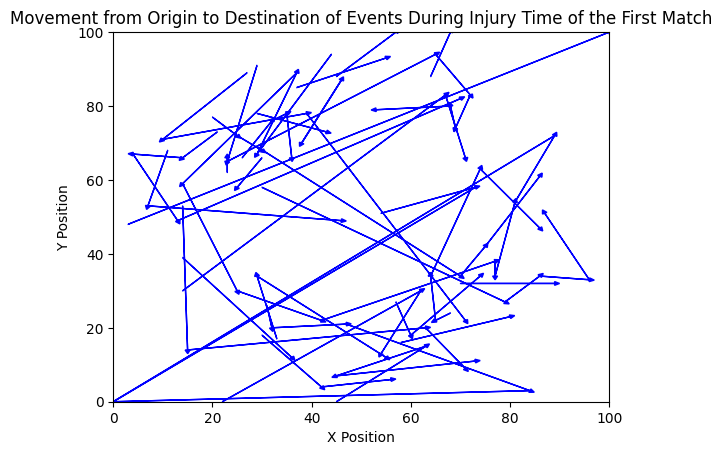

In [72]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot arrows for movements
for i in range(len(matchExample['pos_orig_x'])):
    ax.arrow(matchExample['pos_orig_x'][i], matchExample['pos_orig_y'][i], 
             matchExample['pos_dest_x'][i] - matchExample['pos_orig_x'][i],
             matchExample['pos_dest_y'][i] - matchExample['pos_orig_y'][i],
             head_width=1, head_length=1, fc='blue', ec='blue')

# Set limits and labels
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Movement from Origin to Destination of Events During Injury Time of the First Match')

# Show the plot
plt.show()

# Matches

In [73]:
matches = pd.read_csv('data/matches_England.csv')

In [74]:
matches.head(2)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,...,team2.side,team2.teamId,team2.score,team2.scoreP,team2.hasFormation,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2",...,away,1659,2,0,1,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0,"[{'playerId': 11061, 'ownGoals': '0', 'redCard...","[{'playerId': 259531, 'ownGoals': '0', 'redCar...","[{'playerIn': 7989, 'playerOut': 259531, 'minu..."
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",...,away,1627,0,0,1,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",0,"[{'playerId': 399517, 'ownGoals': '0', 'redCar...","[{'playerId': 25537, 'ownGoals': '0', 'redCard...","[{'playerIn': 261, 'playerOut': 25537, 'minute..."


from https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset?select=matches_England.csv

- **competitionId**: The identifier of the competition to which the match belongs. It is an integer and refers to the field "wyId" of the competition document.
- **date and dateutc**: 
  - *date*: Specifies the date and time when the match starts (e.g., May 20, 2018 at 8:45:00 PM GMT+2).
  - *dateutc*: Contains the same information in compact format (YYYY-MM-DD hh:mm:ss).
- **duration**: 
  - *Regular*: Matches of regular duration (90 minutes + stoppage time).
  - *ExtraTime*: Matches with supplementary times.
  - *Penalities*: Matches ending in penalty kicks.
- **gameweek**: The week of the league, starting from the beginning of the league.
- **label**: Contains the names of the two clubs and the result (e.g., "Lazio - Internazionale, 2 - 3").
- **roundID**: Indicates the match-day of the competition. It specifies the stage of the competition for national teams.
- **seasonId**: Indicates the season of the match.
- **status**: 
  - *Played*: The match has officially finished.
  - *Cancelled*: The match has been canceled.
  - *Postponed*: The match has been postponed with no new date available.
  - *Suspended*: The match has been suspended with no new date available.
- **venue**: The stadium where the match was held (e.g., "Stadio Olimpico").
- **winner**: The identifier of the team that won the game or 0 if the match ended in a draw.
- **wyId**: The identifier of the match, assigned by Wyscout.
- **teamsData**: Contains subfields with information about each team:
  - **hasFormation**: 0 if no formation is present, 1 otherwise.
  - **score**: Goals scored by the team (not counting penalties).
  - **scoreET**: Goals scored during the match, including extra time (not counting penalties).
  - **scoreHT**: Goals scored during the first half.
  - **scoreP**: Total goals scored after penalties.
  - **side**: Team side in the match ("home" or "away").
  - **teamId**: The identifier of the team.
  - **coachId**: The identifier of the team's coach.
  - **bench**: Players who started on the bench and their performance statistics.
  - **lineup**: Players in the starting lineup and their performance statistics.
  - **substitutions**: The list of substitutions made during the match.


In [75]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   status                         380 non-null    object
 1   roundId                        380 non-null    int64 
 2   gameweek                       380 non-null    int64 
 3   teamsData                      380 non-null    object
 4   seasonId                       380 non-null    int64 
 5   dateutc                        380 non-null    object
 6   winner                         380 non-null    int64 
 7   venue                          380 non-null    object
 8   wyId                           380 non-null    int64 
 9   label                          380 non-null    object
 10  date                           380 non-null    object
 11  referees                       380 non-null    object
 12  duration                       380 non-null    object
 13  compe

data looks pretty complete (a couple of null values which I will investigate)

Also there are 380 rows, which is exactly how many matches is played in league season. So all matches seem to be accounted for.


In [76]:
matches.describe()

,roundId,gameweek,seasonId,winner,wyId,competitionId,team1.scoreET,team1.coachId,team1.teamId,team1.score,team1.scoreP,team1.hasFormation,team1.scoreHT,team2.scoreET,team2.coachId,team2.teamId,team2.score,team2.scoreP,team2.hasFormation,team2.scoreHT
count,380.0,380.000000,380.0,380.000000,3.800000e+02,380.0,380.0,380.000000,380.000000,380.000000,380.0,380.0,380.000000,380.0,380.000000,380.000000,380.000000,380.0,380.0,380.000000
mean,4405654.0,19.500000,181150.0,1381.492105,2.499908e+06,364.0,0.0,63666.863158,1867.700000,1.323684,0.0,1.0,0.550000,0.0,133836.065789,2283.100000,1.355263,0.0,1.0,0.571053
std,0.0,10.980313,0.0,1522.719128,1.098408e+02,0.0,0.0,102887.617801,1426.250341,1.308776,0.0,0.0,0.765431,0.0,133249.059527,2329.324772,1.242433,0.0,0.0,0.787571
min,4405654.0,1.000000,181150.0,0.000000,2.499719e+06,364.0,0.0,0.000000,1609.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,1609.000000,0.000000,0.0,1.0,0.000000
25%,4405654.0,10.000000,181150.0,0.000000,2.499814e+06,364.0,0.0,8093.000000,1613.000000,0.000000,0.0,1.0,0.000000,0.0,8329.000000,1619.000000,0.000000,0.0,1.0,0.000000
50%,4405654.0,19.500000,181150.0,1613.000000,2.499908e+06,364.0,0.0,8934.000000,1628.000000,1.000000,0.0,1.0,0.000000,0.0,71037.000000,1625.000000,1.000000,0.0,1.0,0.000000
75%,4405654.0,29.000000,181150.0,1628.000000,2.500003e+06,364.0,0.0,71037.000000,1651.000000,2.000000,0.0,1.0,1.000000,0.0,267136.000000,1639.000000,2.000000,0.0,1.0,1.000000
max,4405654.0,38.000000,181150.0,10531.000000,2.500098e+06,364.0,0.0,531745.000000,10531.000000,7.000000,0.0,1.0,4.000000,0.0,434992.000000,10531.000000,6.000000,0.0,1.0,4.000000


I will tidy some of these columns up. I will remove what I can right now because its a lot of columns (38)

In [77]:
#all matches have the same seasonId so I can delete this.
matches['seasonId'].value_counts()

seasonId
181150    380
Name: count, dtype: int64

In [78]:
matches.nunique()

status                             1
roundId                            1
gameweek                          38
teamsData                        380
seasonId                           1
dateutc                          212
winner                            21
venue                             20
wyId                             380
label                            380
date                             212
referees                         357
duration                           1
competitionId                      1
team1.scoreET                      1
team1.coachId                     28
team1.side                         2
team1.teamId                      19
team1.score                        7
team1.scoreP                       1
team1.hasFormation                 1
team1.formation                  380
team1.scoreHT                      5
team1.formation.bench            380
team1.formation.lineup           380
team1.formation.substitutions    377
team2.scoreET                      1
t

In [79]:
matches[['status','roundId','seasonId','duration','competitionId','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation']].drop_duplicates()

,status,roundId,seasonId,duration,competitionId,team1.scoreET,team1.scoreP,team1.hasFormation,team2.scoreET,team2.scoreP,team2.hasFormation
0,Played,4405654,181150,Regular,364,0,0,1,0,0,1


status shows that all matches were played

the roundId is not applicable to the league format

the seasonId is the same for all 

duration is always regular (no extra time or penos)

competitionId is always the same 

team1/2.scoreET it is never ET

team1/2.scoreP it is never penos

team1/2.hasFormation every team has a formation

I can drop date also, because dateutc has the same information

so i can delete those 11 columns :)

In [80]:
matches.drop(['status','roundId','seasonId','duration','competitionId','team1.scoreET','team1.scoreP','team1.hasFormation','team2.scoreET','team2.scoreP','team2.hasFormation','date'], axis=1, inplace=True)

the teamsData columns is already parsed into the rest of the table in various columns. So I can remove that data.
Likewise with team1.formation and team2.formation

In [81]:
matches['venue'].value_counts()

venue
Turf Moor                                 19
Selhurst Park                             19
The John Smith's Stadium                  19
Anfield                                   19
Old Trafford                              19
St. James' Park                           19
St. Mary's Stadium                        19
Liberty Stadium                           19
Wembley Stadium                           19
London Stadium                            19
Etihad Stadium                            19
King Power Stadium                        19
Stamford Bridge                           19
Emirates Stadium                          19
Goodison Park                             19
Vitality Stadium                          19
Vicarage Road Stadium                     19
The Hawthorns                             19
Bet365 Stadium                            19
The American Express Community Stadium    19
Name: count, dtype: int64

There is no need to keep venue either because that information is already effectively captured in the team1.side and team2.side columns 

In [82]:
matches.drop(['venue'], axis=1, inplace=True)

theres a lot of dictionary columns to investigate!

In [83]:
matches.head(2)

,gameweek,teamsData,dateutc,winner,wyId,label,referees,team1.coachId,team1.side,team1.teamId,...,team1.formation.substitutions,team2.coachId,team2.side,team2.teamId,team2.score,team2.formation,team2.scoreHT,team2.formation.bench,team2.formation.lineup,team2.formation.substitutions
0,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",2018-05-13 14:00:00,1659,2500089,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",8880,home,1646,...,"[{'playerIn': 9127, 'playerOut': 9206, 'minute...",8934,away,1659,2,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0,"[{'playerId': 11061, 'ownGoals': '0', 'redCard...","[{'playerId': 259531, 'ownGoals': '0', 'redCar...","[{'playerIn': 7989, 'playerOut': 259531, 'minu..."
1,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",2018-05-13 14:00:00,1628,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",8357,home,1628,...,"[{'playerIn': 38031, 'playerOut': 8623, 'minut...",0,away,1627,0,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",0,"[{'playerId': 399517, 'ownGoals': '0', 'redCar...","[{'playerId': 25537, 'ownGoals': '0', 'redCard...","[{'playerIn': 261, 'playerOut': 25537, 'minute..."


In [84]:
matches.iloc[0]

gameweek                                                                        38
teamsData                        {'1646': {'scoreET': 0, 'coachId': 8880, 'side...
dateutc                                                        2018-05-13 14:00:00
winner                                                                        1659
wyId                                                                       2500089
label                                             Burnley - AFC Bournemouth, 1 - 2
referees                         [{'refereeId': 385705, 'role': 'referee'}, {'r...
team1.coachId                                                                 8880
team1.side                                                                    home
team1.teamId                                                                  1646
team1.score                                                                      1
team1.formation                  {'bench': [{'playerId': 77502, 'ownGoals': '0'...
team

I will remove the 'team1/2.formation.bench' columns because I dont think that will have any effect on the match. And I already have so much data.

The lineup and substitutions columns are obviously more important here.

In [85]:
matches.drop(['team1.formation.bench','team2.formation.bench'], axis=1, inplace=True)

In [86]:
matches['referees'][0]

"[{'refereeId': 385705, 'role': 'referee'}, {'refereeId': 385733, 'role': 'firstAssistant'}, {'refereeId': 385922, 'role': 'secondAssistant'}, {'refereeId': 388333, 'role': 'fourthOfficial'}]"

The referee column also has the complete information of all 4 referees. I am not expecting the referee to have much impact on the game. but for now, I will parse that data out and join on the name of referee, I will drop the data about the assistants and 4th official.

...although i might do that in a later notebook because this is getting quite complicated

I need to see how I will deal with the team1/2.formation.lineup, and team1/2.formation.substitutions columns

In [87]:
matches['team1.formation.lineup'][0]

"[{'playerId': 9206, 'ownGoals': '0', 'redCards': '0', 'goals': '1', 'yellowCards': '0'}, {'playerId': 93, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 10108, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8433, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8125, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 9433, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8980, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8643, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 12242, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8925, 'ownGoals': '0', 'redCards': '0', 'goals': 'null', 'yellowCards': '0'}, {'playerId': 8284, 'ownGoals': '2', 'redCards': '0', 'goals': '0', 'yellowCards': '0'}]"

In [88]:
matches['team1.formation.substitutions'][0]

"[{'playerIn': 9127, 'playerOut': 9206, 'minute': 61}, {'playerIn': 9179, 'playerOut': 93, 'minute': 80}, {'playerIn': 532949, 'playerOut': 8284, 'minute': 94}]"

I think for now I will also just keep the players in their dictionary columns. I will see later how i plan on using them. I may not use the individual players, I may use some aggregated metrics from them (average team age, average team height, average team weight)

In [89]:
matches.head()

,gameweek,teamsData,dateutc,winner,wyId,label,referees,team1.coachId,team1.side,team1.teamId,...,team1.formation.lineup,team1.formation.substitutions,team2.coachId,team2.side,team2.teamId,team2.score,team2.formation,team2.scoreHT,team2.formation.lineup,team2.formation.substitutions
0,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",2018-05-13 14:00:00,1659,2500089,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",8880,home,1646,...,"[{'playerId': 9206, 'ownGoals': '0', 'redCards...","[{'playerIn': 9127, 'playerOut': 9206, 'minute...",8934,away,1659,2,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0,"[{'playerId': 259531, 'ownGoals': '0', 'redCar...","[{'playerIn': 7989, 'playerOut': 259531, 'minu..."
1,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",2018-05-13 14:00:00,1628,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",8357,home,1628,...,"[{'playerId': 8623, 'ownGoals': '0', 'redCards...","[{'playerIn': 38031, 'playerOut': 8623, 'minut...",0,away,1627,0,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",0,"[{'playerId': 25537, 'ownGoals': '0', 'redCard...","[{'playerIn': 261, 'playerOut': 25537, 'minute..."
2,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",2018-05-13 14:00:00,1609,2500091,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",7845,away,1609,...,"[{'playerId': 25867, 'ownGoals': '0', 'redCard...","[{'playerIn': 7945, 'playerOut': 25867, 'minut...",18572,home,1673,0,"{'bench': [{'playerId': 274482, 'ownGoals': '0...",0,"[{'playerId': 9419, 'ownGoals': '0', 'redCards...","[{'playerIn': 38377, 'playerOut': 9419, 'minut..."
3,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",2018-05-13 14:00:00,1612,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",8093,away,1651,...,"[{'playerId': 120, 'ownGoals': '2', 'redCards'...","[{'playerIn': 15526, 'playerOut': 120, 'minute...",14791,home,1612,4,"{'bench': [{'playerId': 74, 'ownGoals': '0', '...",2,"[{'playerId': 25747, 'ownGoals': '2', 'redCard...","[{'playerIn': 8140, 'playerOut': 25747, 'minut..."
4,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",2018-05-13 14:00:00,1611,2500093,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",93112,away,1644,...,"[{'playerId': 68085, 'ownGoals': '0', 'redCard...","[{'playerIn': 8889, 'playerOut': 68085, 'minut...",3295,home,1611,1,"{'bench': [{'playerId': 7918, 'ownGoals': '0',...",1,"[{'playerId': 7939, 'ownGoals': '0', 'redCards...","[{'playerIn': 8135, 'playerOut': 7939, 'minute..."


### Referees

In [90]:
def convert_to_dict(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)  # Safely evaluate the string to a dict
        except (ValueError, SyntaxError):
            return {}  # Return an empty dict if conversion fails
    elif isinstance(value, dict):
        return value  # Already a dict
    return {}  # Return an empty dict for any other type

In [91]:
# Apply the conversion function to the referees column
matches['referees'] = matches['referees'].apply(convert_to_dict)

In [92]:
referees_expanded = pd.json_normalize(matches['referees'])

In [93]:
# Apply the conversion function to the now expanded referees columns because it was nested at a further level column
referees_expanded[0] = referees_expanded[0].apply(convert_to_dict)

In [94]:
ref_col=pd.json_normalize(referees_expanded[0])[['refereeId']]

In [95]:
#join the ref id column to the matches table
matches = pd.concat([matches, ref_col], axis=1)

In [96]:

# Drop the original referees column
matches = matches.drop(columns=['referees'])

In [97]:
referees = pd.read_csv('data/referees.csv')

In [98]:
referees

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea.id,birthArea.alpha2code,birthArea.alpha3code,birthArea.name,passportArea.id,passportArea.alpha2code,passportArea.alpha3code,passportArea.name
0,378217,A. Guzmán,Alexander,NaN,Guzmán Bonilla,NaN,170,CO,COL,Colombia,170,CO,COL,Colombia
1,385011,S. Bennett,Simon,NaN,Bennett,NaN,826,EN,XEN,England,826,EN,XEN,England
2,385544,H. Osmers,Harm,NaN,Osmers,1985-01-28,276,DE,DEU,Germany,276,DE,DEU,Germany
3,383894,F. Assmuth,Frederick,NaN,Assmuth,1977-12-20,276,DE,DEU,Germany,276,DE,DEU,Germany
4,385800,F. Hebrard,Frédéric,NaN,Hebrard,NaN,250,FR,FRA,France,250,FR,FRA,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,457938,L. Lanotte,Luigi,NaN,Lanotte,NaN,380,IT,ITA,Italy,380,IT,ITA,Italy
622,385918,A. Halliday,Andy,NaN,Halliday,NaN,826,EN,XEN,England,826,EN,XEN,England
623,379973,C. Ramos,César Arturo,NaN,Ramos Palazuelos,1983-12-15,484,MX,MEX,Mexico,484,MX,MEX,Mexico
624,385517,G. Pasqualotti,Gwenaël,NaN,Pasqualotti,NaN,250,FR,FRA,France,250,FR,FRA,France


I dont think I really need any of this information. But I will capture the referee's name in case I use it for some illustrations later

In [99]:
matches=matches.merge(referees[['wyId','shortName']], how='left' , left_on='refereeId', right_on='wyId', suffixes=('', '_referee'))

In [100]:
matches.drop(['refereeId','wyId_referee'], axis=1, inplace=True)

In [101]:
matches=matches.rename(columns={'shortName':'refereeName'})

In [102]:
matches

,gameweek,teamsData,dateutc,winner,wyId,label,team1.coachId,team1.side,team1.teamId,team1.score,...,team1.formation.substitutions,team2.coachId,team2.side,team2.teamId,team2.score,team2.formation,team2.scoreHT,team2.formation.lineup,team2.formation.substitutions,refereeName
0,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",2018-05-13 14:00:00,1659,2500089,"Burnley - AFC Bournemouth, 1 - 2",8880,home,1646,1,...,"[{'playerIn': 9127, 'playerOut': 9206, 'minute...",8934,away,1659,2,"{'bench': [{'playerId': 11061, 'ownGoals': '0'...",0,"[{'playerId': 259531, 'ownGoals': '0', 'redCar...","[{'playerIn': 7989, 'playerOut': 259531, 'minu...",P. Tierney
1,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",2018-05-13 14:00:00,1628,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0",8357,home,1628,2,...,"[{'playerIn': 38031, 'playerOut': 8623, 'minut...",0,away,1627,0,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",0,"[{'playerId': 25537, 'ownGoals': '0', 'redCard...","[{'playerIn': 261, 'playerOut': 25537, 'minute...",J. Moss
2,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",2018-05-13 14:00:00,1609,2500091,"Huddersfield Town - Arsenal, 0 - 1",7845,away,1609,1,...,"[{'playerIn': 7945, 'playerOut': 25867, 'minut...",18572,home,1673,0,"{'bench': [{'playerId': 274482, 'ownGoals': '0...",0,"[{'playerId': 9419, 'ownGoals': '0', 'redCards...","[{'playerIn': 38377, 'playerOut': 9419, 'minut...",NaN
3,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",2018-05-13 14:00:00,1612,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0",8093,away,1651,0,...,"[{'playerIn': 15526, 'playerOut': 120, 'minute...",14791,home,1612,4,"{'bench': [{'playerId': 74, 'ownGoals': '0', '...",2,"[{'playerId': 25747, 'ownGoals': '2', 'redCard...","[{'playerIn': 8140, 'playerOut': 25747, 'minut...",K. Friend
4,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",2018-05-13 14:00:00,1611,2500093,"Manchester United - Watford, 1 - 0",93112,away,1644,0,...,"[{'playerIn': 8889, 'playerOut': 68085, 'minut...",3295,home,1611,1,"{'bench': [{'playerId': 7918, 'ownGoals': '0',...",1,"[{'playerId': 7939, 'ownGoals': '0', 'redCards...","[{'playerIn': 8135, 'playerOut': 7939, 'minute...",L. Mason
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1,"{'1623': {'scoreET': 0, 'coachId': 268779, 'si...",2017-08-12 14:00:00,1623,2499723,"Everton - Stoke City, 1 - 0",9054,away,1639,0,...,"[{'playerIn': 15198, 'playerOut': 20450, 'minu...",268779,home,1623,1,"{'bench': [{'playerId': 20428, 'ownGoals': '0'...",1,"[{'playerId': 77546, 'ownGoals': '0', 'redCard...","[{'playerIn': 340, 'playerOut': 77546, 'minute...",N. Swarbrick
376,1,"{'10531': {'scoreET': 0, 'coachId': 381291, 's...",2017-08-12 14:00:00,0,2499726,"Southampton - Swansea City, 0 - 0",254174,home,1619,0,...,"[{'playerIn': 8953, 'playerOut': 20857, 'minut...",381291,away,10531,0,"{'bench': [{'playerId': 149151, 'ownGoals': '0...",0,"[{'playerId': 77550, 'ownGoals': '0', 'redCard...","[{'playerIn': 62344, 'playerOut': 77550, 'minu...",M. Jones
377,1,"{'1659': {'scoreET': 0, 'coachId': 8934, 'side...",2017-08-12 14:00:00,1627,2499728,"West Bromwich Albion - AFC Bournemouth, 1 - 0",8934,away,1659,0,...,"[{'playerIn': 9739, 'playerOut': 9293, 'minute...",149026,home,1627,1,"{'bench': [{'playerId': 399517, 'ownGoals': '0...",1,"[{'playerId': 434159, 'ownGoals': '0', 'redCar...","[{'playerIn': 447254, 'playerOut': 434159, 'mi...",R. Madley
378,1,"{'1644': {'scoreET': 0, 'coachId': 71037, 'sid...",2017-08-12 11:30:00,0,2499727,"Watford - Liverpool, 3 - 3",14791,away,1612,3,...,"[{'playerIn': 134708, 'playerOut': 15808, 'min...",71037,home,1644,3,"{'bench': [{'playerId': 25798, 'ownGoals': '0'...",2,"[{'playerId': 160, 'ownGoals': '0', 'redCards'...","[{'playerIn': 3351, 'playerOut': 160, 'minute'...",A. Taylor


Later I will replace the winner, team1.coachId, team1.teamId, team2.coachId, team2.teamId with the relevant data from the coaches.csv data set and the teams data set.

### competitions

I can quickly see that this has no relevance to me at the moment. This will only be important if i ever decide to tie in other competitions apart from the english premier league.

In [103]:
competitions= pd.read_csv('data/competitions.csv')

In [104]:
competitions

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


In [105]:
competitions['area'][1]

"{'name': 'England', 'id': '0', 'alpha3code': 'XEN', 'alpha2code': ''}"

### coaches

In [106]:
coaches= pd.read_csv('data/coaches.csv')

In [107]:
coaches

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,NaN,Mendiondo López,NaN,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,NaN,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,NaN,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,NaN,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,NaN,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0
...,...,...,...,...,...,...,...,...,...
203,264939,José Miguel Campos,José Miguel,NaN,Campos Rodríguez,1966-08-12,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",0
204,26213,M. Der Zakarian,Michel,NaN,Der Zakarian,1963-02-18,"{'id': 51, 'alpha2code': 'AM', 'alpha3code': '...","{'id': 51, 'alpha2code': 'AM', 'alpha3code': '...",3787
205,7845,A. Wenger,Arsène,NaN,Wenger,1949-10-22,"{'id': 250, 'alpha2code': 'FR', 'alpha3code': ...","{'id': 250, 'alpha2code': 'FR', 'alpha3code': ...",0
206,3485,Mendilibar,José Luis,NaN,Mendilibar Etxebarria,1961-03-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",701
